In [68]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 999

In [191]:
CLIENT_ID = '53LUJBTBAEFNV5HS3VTTJ5DP3WCODD4SBENMHE4MOCKR5TGK' # your Foursquare ID
CLIENT_SECRET = 'BJ0P4G2WIEOU5FKWHEUGCOARY2NZYXMPXIFWU5ZPVN5MSZJR' # your Foursquare Secret
VERSION = '20180605' # Foursquare
LIMIT=500
radius=1000

In [156]:
# Some pre-defined lists are defines here. 
    # List of city names
    # Definition of low and high price groups
    # Category Names
    # IDs for Categories
    # Weightage for each Category

cityName=['Athens, Greece','Paris, France','Prague, Czech Republic','Vienna, Austria','Madrid, Spain','Rome, Italy']
cityName = sorted(cityName)
pricesL = '1'
pricesH = '2,3,4'
section = 'trending'

CatNames = ['Museum','Shops and Service', 'Italian Restaurant', 'Bars', 'Outdoors and Recreation']
Cats =  ['4bf58dd8d48988d181941735','4bf58dd8d48988d103951735,4bf58dd8d48988d127951735,4bf58dd8d48988d128951735,5744ccdfe4b0c0459246b4df,4bf58dd8d48988d1fd941735',
         '4bf58dd8d48988d110941735','4bf58dd8d48988d116941735','4d4b7105d754a06377d81259']
CatWeights = [0.4,0.05,0.1,0.3,0.15]


['Athens, Greece',
 'Madrid, Spain',
 'Paris, France',
 'Prague, Czech Republic',
 'Rome, Italy',
 'Vienna, Austria']

In [71]:
# Function to get the latitude and longitude of a city using nominatim API
# returns two lists - One containing lats and other longs

def GetLatLongs(cityName):
    lats=[]
    longs = []
    
    for cname in zip(cityName):
        url =  'https://nominatim.openstreetmap.org/search?q={}&format=json&limit=1&addressdetails=1'.format(
                        cname
                        )
        llResults =  requests.get(url).json()
        lats.append(llResults[0]['lat'])  
        longs.append(llResults[0]['lon']) 
        
    return lats,longs

In [72]:
# Gets the lats and longs of all cities using 'GetLatLongs' function
cityLat, cityLong = GetLatLongs(cityName)

In [73]:
# Function to know if a venue is a low cost or high cost 

def GetVenuePricing(venLat, venLng, price):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}&section={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                venLat, 
                venLng, 
                radius, 
                LIMIT,
                price,
                section
                )
    
    try:
        totResults =  requests.get(url).json()['response']['totalResults']
    except:
        totResults = 0
    
    return totResults

In [74]:
# Function to generate the main dataset which is used for further analysis
# Loops thru the list of cities
# Then loops thru each category
# Gets the top 50 venues in a Venue in a city for a particular category
# Gets the count of likes for each venue
# Gets the counts for low price and counts for high price
# All this data is stored in a new dataframe
# This dataframe is returned back

def GetVenueLikes(citynames, lats, longs, CatNames):
    venues_list=[]
    for cn, lat, lng in zip(citynames, lats, longs):
        print(str(lat) + '  ' + str(lng) + '    ' + cn)
        if not (str(lat) == '' or str(lng)==''):
            # create the API request URL
            for category,cname in zip(Cats,CatNames):
                url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    lat,
                    lng,
                    VERSION,
                    category,
                    radius, 
                    LIMIT
                    )

                print('Cat  ' + category)
                # make the GET request
                #print(requests.get(url).json())
                results_VE = requests.get(url).json()['response']['venues']
                              
                cnt=0
                cat_likes_cnt=0
                
                for venue in results_VE:
                    vid=venue['id']
                    vlat = venue['location']['lat']
                    vlng = venue['location']['lng']
                    print('VID = ' + vid)
                    cnt += 1
                    url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}&VENUE_ID={}&limit={}'.format(
                        vid,
                        CLIENT_ID, 
                        CLIENT_SECRET, 
                        VERSION, 
                        vid,
                        LIMIT
                        )

                    results_V = requests.get(url).json()
                    
                    try:
                        ve_count = results_V["response"]["likes"]["count"]
                    except:
                        ve_count = 0
                    
                    cat_likes_cnt = cat_likes_cnt + ve_count
                    
                    priceLow = GetVenuePricing(vlat, vlng, pricesL)
                    priceHigh = GetVenuePricing(vlat, vlng, pricesH)
                                            
                    venues_list.append([(         
                        cn,
                        lat,
                        lng,
                        venue['name'], 
                        venue['location']['lat'], 
                        venue['location']['lng'],  
                        venue['categories'][0]['name'],
                        ve_count,
                        cname,
                        priceLow,
                        priceHigh
                        )])
                    
                print('City: ' + cn + ' ; Category Name: ' + venue['categories'][0]['name'] + ' ; Venue Count: ' + str(cnt) + ' ; Cat like Count: ' + str(cat_likes_cnt))

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['CityName',
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Likes',
                  'Parent Category Name',
                  'Trending Price Low',
                  'Trending Price High']
    
    return(nearby_venues)

In [75]:
# Gets the weighted likes for each venue

def GetWeighted(row):
    
    CatName = row['Parent Category Name'];
    CatIndex = CatNames.index(CatName)
    
    CatWeight = CatWeights[CatIndex]
    
    return row['Venue Likes'] * CatWeight

In [76]:
# Gets the dataframe with all the required data from foursquare API
VenueData = None
VenueData = GetVenueLikes(cityName,cityLat,cityLong,CatNames)

37.9841493  23.7279843    Athens, Greece
Cat  4bf58dd8d48988d181941735
VID = 4e96f51e2c5be852ff223b42
VID = 5b98ce801ffe97002cd73e14
VID = 4adcdadff964a520735821e3
VID = 4befc8ad51f2c9b685e7f092
VID = 4adcdadff964a5206c5821e3
VID = 4e46b6557d8b91a065929c08
VID = 544f71b4498ef327cc05f229
VID = 4adcdadff964a520665821e3
VID = 4d5d6bb4fb186dcbcd080c9b
VID = 5307377e498ef9b8cb8ae520
VID = 555876f0498eb8398d61ccd1
VID = 5881dfb3966e551ef8411c81
VID = 523da56611d26f235c6e78cb
VID = 4e872f4acc2183252e28cbb1
VID = 533be558498ec509167e1a89
VID = 5c13d2a88a4cf5002cc90a44
VID = 54dc9fe8498ed8bc5180f931
VID = 4da35d0263b5a35dc58c101a
VID = 54ccbe6f498e0db58a575878
VID = 50129909e4b0abd874e5b0e7
VID = 50caddffe4b05a3b8c481dfe
VID = 56af8e93498e88c71ad576b3
VID = 54561156498eefcc84a7fb92
VID = 4e849b7161af43c992e5d523
VID = 586681883e883556793af47d
VID = 5996be7ba795bd460e16fbff
VID = 51975c2b498eebbaf656ee6b
VID = 4e7f62ec29c22b8f3286688b
VID = 57969e92498e07f570e7b11b
VID = 523b1fe2498e256cb368b70d

In [77]:
VenueData.shape

(1205, 11)

In [78]:
VenueData.describe()

,Venue Latitude,Venue Longitude,Venue Likes,Trending Price Low,Trending Price High
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,44.800494,11.298638,209.184232,33.402490,96.198340
std,4.689310,8.938816,533.947693,13.499163,29.801358
min,37.975385,-3.714516,0.000000,0.000000,0.000000
25%,40.419142,2.352669,15.000000,27.000000,93.000000
50%,48.204152,14.415962,52.000000,35.000000,103.000000
75%,48.858559,16.370905,158.000000,42.000000,114.000000
max,50.096207,23.738263,6831.000000,69.000000,132.000000


In [79]:
VenueData.head(10)

,CityName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Likes,Parent Category Name,Trending Price Low,Trending Price High
0,"Athens, Greece",37.9841493,23.7279843,Hellenic Motor Museum (Ελληνικό Μουσείο Αυτοκι...,37.991397,23.730054,Museum,119,Museum,57,47
1,"Athens, Greece",37.9841493,23.7279843,Museum of illusions,37.976844,23.722807,Museum,19,Museum,58,96
2,"Athens, Greece",37.9841493,23.7279843,National Archaeological Museum (Εθνικό Αρχαιολ...,37.989026,23.732529,History Museum,796,Museum,67,61
3,"Athens, Greece",37.9841493,23.7279843,Museum of Islamic Art (Μουσείο Ισλαμικής Τέχνης),37.979228,23.720305,Art Museum,55,Museum,51,103
4,"Athens, Greece",37.9841493,23.7279843,Museum of the City of Athens (Μουσείο της Πόλε...,37.979077,23.731573,History Museum,19,Museum,49,103
5,"Athens, Greece",37.9841493,23.7279843,Numismatic Museum (Νομισματικό Μουσείο),37.977851,23.735339,Museum,119,Museum,49,105
6,"Athens, Greece",37.9841493,23.7279843,Korai 4 Memorial Site 1941-1944 (Χώρος Ιστορικ...,37.980156,23.732588,History Museum,4,Museum,49,106
7,"Athens, Greece",37.9841493,23.7279843,National Historical Museum (Εθνικό Ιστορικό Μο...,37.977981,23.733056,History Museum,16,Museum,47,0
8,"Athens, Greece",37.9841493,23.7279843,Athens Municipal Gallery (Δημοτική Πινακοθήκη ...,37.983307,23.719633,Art Museum,15,Museum,0,98
9,"Athens, Greece",37.9841493,23.7279843,Το Αρχοντικό των Μπενιζέλων,37.975946,23.727980,Museum,5,Museum,49,103


In [178]:
# We are interested in how many people mentioned that this is a low price venue. So we add a new column with percentage of low cost reply vs the total replies.
VenueData['Price Low %'] = round((VenueData['Trending Price Low'] * 100)/(VenueData['Trending Price Low'] + VenueData['Trending Price High']),2)

In [179]:
VenueData.head(10)

,CityName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Likes,Parent Category Name,Trending Price Low,Trending Price High,Price Low %,Weighted_Likes
0,"Athens, Greece",37.9841493,23.7279843,Hellenic Motor Museum (Ελληνικό Μουσείο Αυτοκι...,37.991397,23.730054,Museum,119,Museum,57,47,54.81,47.6
1,"Athens, Greece",37.9841493,23.7279843,Museum of illusions,37.976844,23.722807,Museum,19,Museum,58,96,37.66,7.6
2,"Athens, Greece",37.9841493,23.7279843,National Archaeological Museum (Εθνικό Αρχαιολ...,37.989026,23.732529,History Museum,796,Museum,67,61,52.34,318.4
3,"Athens, Greece",37.9841493,23.7279843,Museum of Islamic Art (Μουσείο Ισλαμικής Τέχνης),37.979228,23.720305,Art Museum,55,Museum,51,103,33.12,22.0
4,"Athens, Greece",37.9841493,23.7279843,Museum of the City of Athens (Μουσείο της Πόλε...,37.979077,23.731573,History Museum,19,Museum,49,103,32.24,7.6
5,"Athens, Greece",37.9841493,23.7279843,Numismatic Museum (Νομισματικό Μουσείο),37.977851,23.735339,Museum,119,Museum,49,105,31.82,47.6
6,"Athens, Greece",37.9841493,23.7279843,Korai 4 Memorial Site 1941-1944 (Χώρος Ιστορικ...,37.980156,23.732588,History Museum,4,Museum,49,106,31.61,1.6
7,"Athens, Greece",37.9841493,23.7279843,National Historical Museum (Εθνικό Ιστορικό Μο...,37.977981,23.733056,History Museum,16,Museum,47,0,100.00,6.4
8,"Athens, Greece",37.9841493,23.7279843,Athens Municipal Gallery (Δημοτική Πινακοθήκη ...,37.983307,23.719633,Art Museum,15,Museum,0,98,0.00,6.0
9,"Athens, Greece",37.9841493,23.7279843,Το Αρχοντικό των Μπενιζέλων,37.975946,23.727980,Museum,5,Museum,49,103,32.24,2.0


In [82]:
VenueData_Counts = VenueData['CityName'].value_counts()
VenueData_Counts

Prague, Czech Republic    227
Vienna, Austria           214
Athens, Greece            201
Paris, France             194
Madrid, Spain             185
Rome, Italy               184
Name: CityName, dtype: int64

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


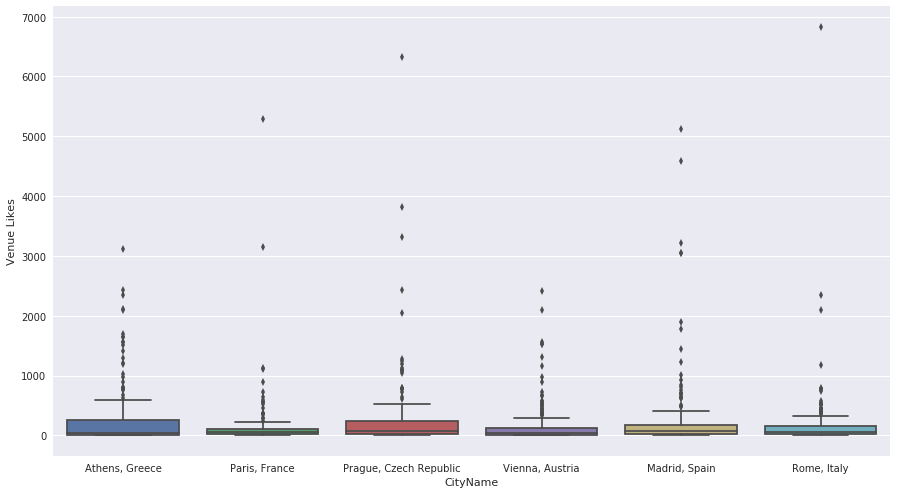

In [164]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.boxplot(x='CityName',y='Venue Likes',data = VenueData)

In [84]:
# Sliced database with city name, category name, and likes for that venue
VenueDataLikes = VenueData[['CityName','Parent Category Name','Venue Likes']]
VenueDataLikes

,CityName,Parent Category Name,Venue Likes
0,"Athens, Greece",Museum,119
1,"Athens, Greece",Museum,19
2,"Athens, Greece",Museum,796
3,"Athens, Greece",Museum,55
4,"Athens, Greece",Museum,19
5,"Athens, Greece",Museum,119
6,"Athens, Greece",Museum,4
7,"Athens, Greece",Museum,16
8,"Athens, Greece",Museum,15
9,"Athens, Greece",Museum,5


In [154]:
# Group data by Cityname and category name
VenueDataLikes_Grp = VenueDataLikes.groupby(['CityName','Parent Category Name'], as_index=False).sum()

In [155]:
# Gets the Venue likes for a city 
VenueDataLikes_Grp_Mean = VenueDataLikes_Grp.groupby('CityName').mean()
VenueDataLikes_Grp_Mean

,Venue Likes
CityName,
"Athens, Greece",10441.2
"Madrid, Spain",9797.8
"Paris, France",5552.8
"Prague, Czech Republic",11354.0
"Rome, Italy",6638.6
"Vienna, Austria",6629.0


In [87]:
VenueDataLikes_Pivot = VenueDataLikes_Grp.pivot(index='CityName',columns='Parent Category Name')
VenueDataLikes_Pivot

Venue Likes                            \
Parent Category Name          Bars Italian Restaurant Museum   
CityName                                                       
Athens, Greece               36954                648   1212   
Madrid, Spain                 9557               1839  12658   
Paris, France                 4986               1350   7227   
Prague, Czech Republic       20684               7810   2910   
Rome, Italy                   5471               7263   2185   
Vienna, Austria               8066               3448   7719   

                                                                  
Parent Category Name   Outdoors and Recreation Shops and Service  
CityName                                                          
Athens, Greece                           11093              2299  
Madrid, Spain                            22140              2795  
Paris, France                            10983              3218  
Prague, Czech Republic                   18933              6433  
Rome, Italy                              16864              1410  
Vienna, Austria                          12115              1797

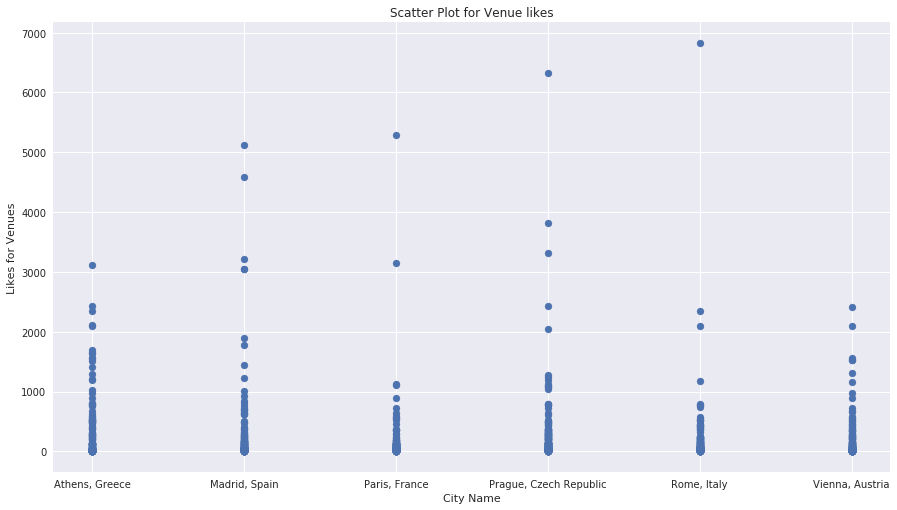

In [162]:
# Draw a scatter plot
plt.scatter(VenueData['CityName'],VenueData['Venue Likes'])
plt.xlabel("City Name")
plt.ylabel("Likes for Venues")
plt.title("Scatter Plot for Venue likes")
plt.show()

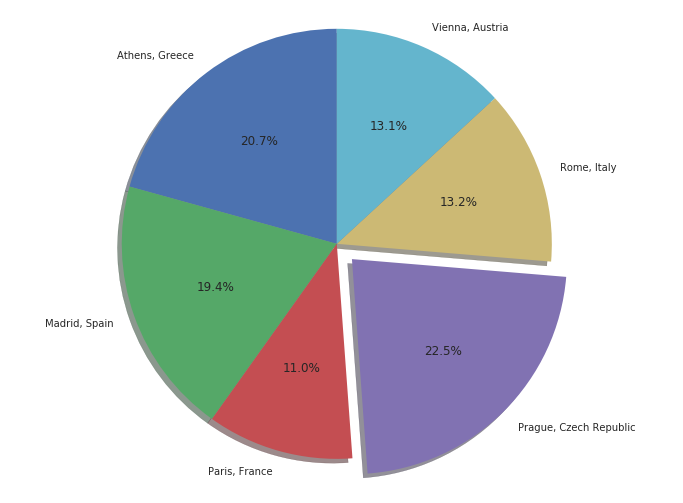

In [157]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# the pie with maximum likes will be exploded

sizes = VenueDataLikes_Grp_Mean['Venue Likes']

#explode = (0, 0.1, 0, 0,0, 0)  # only "explode" the 2nd slice 
indexToExplode = cityName.index(max(VenueDataLikes_Grp_Mean.idxmax()))
explode=[]
for j in range(len(cityName)):
    if (j == indexToExplode):
        explode.append(0.1) 
    else:
        explode.append(0) 


fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=cityName, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()

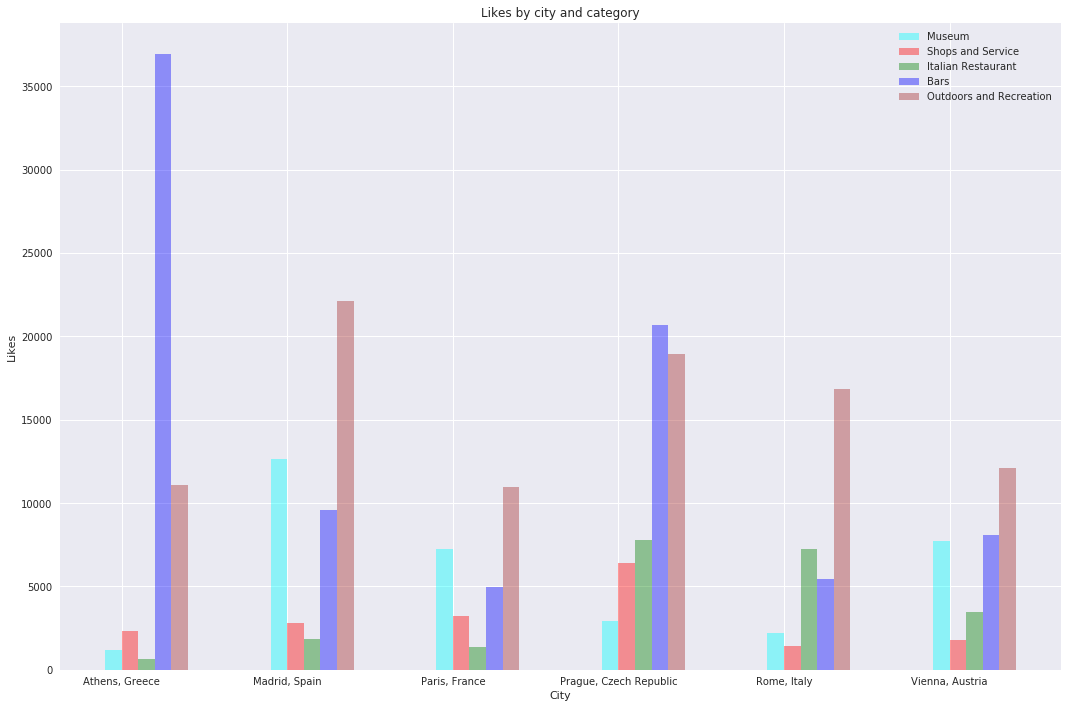

In [165]:
# Draw bar chart which displays likes for all cities and categories grouped by city

bar_colors = ['cyan', 'red', 'green', 'blue',  'brown', 'darkorange','Navy','SlateGrey','Purple','Tomato']

n_groups = len(cityName)
fig, ax = plt.subplots(figsize=(15, 10))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.4
error_config = {'ecolor': '0.3'}
cat_count = len(CatNames)  #3
#print(cat_count)
for i in range(cat_count):
    #print(str(i) + '   ' + CatNames[i])
    bar_data = VenueDataLikes_Grp.loc[VenueDataLikes_Grp['Parent Category Name'] == CatNames[i]].iloc[:,2]
    #print(bar_data)
    ax.bar((index + (bar_width * i)), bar_data, bar_width, alpha=opacity, color=bar_colors[i],label=CatNames[i])
    
ax.set_xlabel('City')
ax.set_ylabel('Likes')
ax.set_title('Likes by city and category')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cityName)
ax.legend()

fig.tight_layout()
plt.show()

In [99]:
VenueData.head(5)

,CityName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Likes,Parent Category Name,Trending Price Low,Trending Price High,Price Low %
0,"Athens, Greece",37.9841493,23.7279843,Hellenic Motor Museum (Ελληνικό Μουσείο Αυτοκι...,37.991397,23.730054,Museum,119,Museum,57,47,54.807692
1,"Athens, Greece",37.9841493,23.7279843,Museum of illusions,37.976844,23.722807,Museum,19,Museum,58,96,37.662338
2,"Athens, Greece",37.9841493,23.7279843,National Archaeological Museum (Εθνικό Αρχαιολ...,37.989026,23.732529,History Museum,796,Museum,67,61,52.343750
3,"Athens, Greece",37.9841493,23.7279843,Museum of Islamic Art (Μουσείο Ισλαμικής Τέχνης),37.979228,23.720305,Art Museum,55,Museum,51,103,33.116883
4,"Athens, Greece",37.9841493,23.7279843,Museum of the City of Athens (Μουσείο της Πόλε...,37.979077,23.731573,History Museum,19,Museum,49,103,32.236842


In [100]:
# Add a new column to the dataframe using category weights
# Users may want to provide a weightage for each category
# So likes for venues are mutiplied by weight for that vategory in which venue falls
VenueData['Weighted_Likes'] = VenueData.apply(GetWeighted, axis=1)

In [101]:
VenueData.head(5)

,CityName,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Likes,Parent Category Name,Trending Price Low,Trending Price High,Price Low %,Weighted_Likes
0,"Athens, Greece",37.9841493,23.7279843,Hellenic Motor Museum (Ελληνικό Μουσείο Αυτοκι...,37.991397,23.730054,Museum,119,Museum,57,47,54.807692,47.6
1,"Athens, Greece",37.9841493,23.7279843,Museum of illusions,37.976844,23.722807,Museum,19,Museum,58,96,37.662338,7.6
2,"Athens, Greece",37.9841493,23.7279843,National Archaeological Museum (Εθνικό Αρχαιολ...,37.989026,23.732529,History Museum,796,Museum,67,61,52.343750,318.4
3,"Athens, Greece",37.9841493,23.7279843,Museum of Islamic Art (Μουσείο Ισλαμικής Τέχνης),37.979228,23.720305,Art Museum,55,Museum,51,103,33.116883,22.0
4,"Athens, Greece",37.9841493,23.7279843,Museum of the City of Athens (Μουσείο της Πόλε...,37.979077,23.731573,History Museum,19,Museum,49,103,32.236842,7.6


In [102]:
VenueDataWtdLikes = VenueData[['CityName','Parent Category Name','Weighted_Likes']]
VenueDataWtdLikes

,CityName,Parent Category Name,Weighted_Likes
0,"Athens, Greece",Museum,47.60
1,"Athens, Greece",Museum,7.60
2,"Athens, Greece",Museum,318.40
3,"Athens, Greece",Museum,22.00
4,"Athens, Greece",Museum,7.60
5,"Athens, Greece",Museum,47.60
6,"Athens, Greece",Museum,1.60
7,"Athens, Greece",Museum,6.40
8,"Athens, Greece",Museum,6.00
9,"Athens, Greece",Museum,2.00


In [122]:
VenueDataWtdLikes_Grp = VenueDataWtdLikes.groupby(['CityName','Parent Category Name']).sum()
VenueDataWtdLikes_Grp_Mean = VenueDataWtdLikes_Grp.groupby('CityName').mean()
VenueDataWtdLikes_Grp_Mean

,Weighted_Likes
CityName,
"Athens, Greece",2682.94
"Madrid, Spain",2314.99
"Paris, France",1265.99
"Prague, Czech Republic",2262.36
"Rome, Italy",1168.34
"Vienna, Austria",1551.86


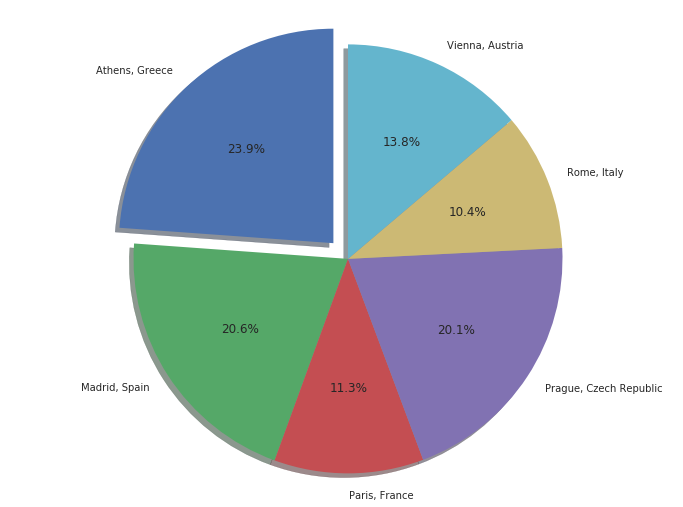

In [159]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# the pie with maximum likes will be exploded

sizes = VenueDataWtdLikes_Grp_Mean['Weighted_Likes']

indexToExplode = cityName.index(max(VenueDataWtdLikes_Grp_Mean.idxmax()))
explode=[]
for j in range(len(cityName)):
    if (j == indexToExplode):
        explode.append(0.1) 
    else:
        explode.append(0) 

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=cityName, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()

In [180]:
# Gets a sliced dataframe with City, Categry, and Low price %

VenueDataCost = VenueData[['CityName','Parent Category Name','Price Low %']]
VenueDataCost

,CityName,Parent Category Name,Price Low %
0,"Athens, Greece",Museum,54.81
1,"Athens, Greece",Museum,37.66
2,"Athens, Greece",Museum,52.34
3,"Athens, Greece",Museum,33.12
4,"Athens, Greece",Museum,32.24
5,"Athens, Greece",Museum,31.82
6,"Athens, Greece",Museum,31.61
7,"Athens, Greece",Museum,100.00
8,"Athens, Greece",Museum,0.00
9,"Athens, Greece",Museum,32.24


In [181]:
VenueDataCost_Grp = VenueDataCost.groupby(['CityName','Parent Category Name'], as_index=False).sum()

In [182]:
VenueDataCost_Grp_Mean = VenueDataCost_Grp.groupby('CityName').mean()
VenueDataCost_Grp_Mean

,Price Low %
CityName,
"Athens, Greece",1377.692
"Madrid, Spain",903.448
"Paris, France",1185.598
"Prague, Czech Republic",1434.042
"Rome, Italy",1092.974
"Vienna, Austria",935.906


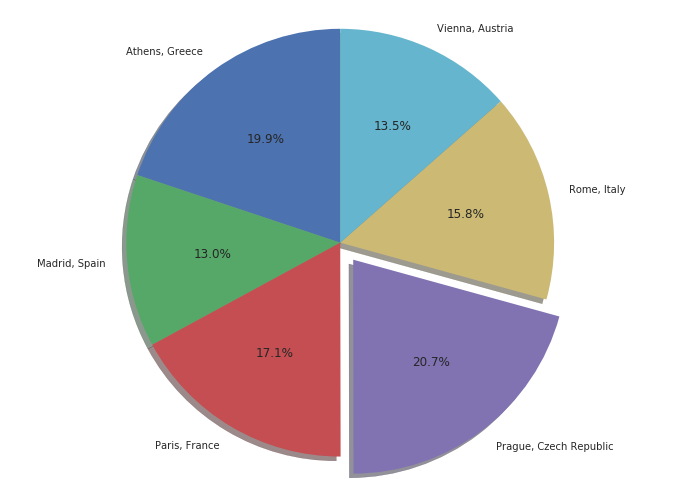

In [183]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# the pie with maximum likes will be exploded

sizes = VenueDataCost_Grp_Mean['Price Low %']

indexToExplode = cityName.index(max(VenueDataCost_Grp_Mean.idxmax()))
explode=[]
for j in range(len(cityName)):
    if (j == indexToExplode):
        explode.append(0.1) 
    else:
        explode.append(0) 

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=cityName, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()

In [190]:
# Final dataframe created by merging three dataframes, which displays the 'venue Likes', 'Weighted Likes', and 'Lost Cost %' for all cities

# VenueDataLikes_Grp_Mean
# VenueDataWtdLikes_Grp_Mean
# VenueDataCost_Grp_Mean

AllFrames = [round(VenueDataLikes_Grp_Mean,2), VenueDataWtdLikes_Grp_Mean, round(VenueDataCost_Grp_Mean,2)]

ResultAnalysis  = pd.concat(AllFrames, axis=1)

ResultAnalysis.columns= ['Venue Likes','Weighted Like','Low Cost']

ResultAnalysis

,Venue Likes,Weighted Like,Low Cost
CityName,,,
"Athens, Greece",10441.2,2682.94,1377.69
"Madrid, Spain",9797.8,2314.99,903.45
"Paris, France",5552.8,1265.99,1185.60
"Prague, Czech Republic",11354.0,2262.36,1434.04
"Rome, Italy",6638.6,1168.34,1092.97
"Vienna, Austria",6629.0,1551.86,935.91
